In [1]:
import gym
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import deque
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
# from tensorflow.keras.models import load_model



## Build Model
<!-- <h3>Base Model</h3> -->
- Epsilon = 1
- Epsilon_min = 0.01
- Epsilon_decay = 0.99
- Learning_rate = 0.01
- Discount_rate = 0.8
- Train_start = 1000
- Batch_size = 64

In [9]:
EPISODES = 300

In [10]:
class DQNAgent:
    def __init__(self, state_size, action_size, epsilon_decay=0.99, learning_rate=0.01, discount_rate=0.8, n_discrete_actions=10, weights=None):
        self.state_size = state_size
        self.action_size = action_size

        self.render = False

        self.epsilon = 1
        self.epsilon_min = 0.01 
        self.epsilon_decay = epsilon_decay 
        self.learning_rate = learning_rate 
        self.discount_rate = discount_rate 
        self.train_start = 1000
        self.batch_size = 64

        self.n_discrete_actions = n_discrete_actions 
        self.action_space = np.linspace(-2, 2, self.n_discrete_actions)

        self.memory = deque(maxlen=3000)

        self.model = self.build_model()
        if weights != None:
            self.model.load_weights(weights)
        self.t_model = self.build_model()
        self.update_t_weights()

    def build_model(self):
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation="relu"))
        model.add(Dense(24, activation="relu"))
        model.add(Dense(self.n_discrete_actions, activation="linear"))
        model.summary()
        model.compile(loss="mse", optimizer=Adam(lr=self.learning_rate))
        return model
    
    def decay(self):
                # Epsilon Decay
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            
    def append_sample(self, state, action, reward, next_state, done):
        # Replay Buffer
        self.memory.append((state, action, reward, next_state, done))



    def update_t_weights(self):
        self.t_model.set_weights(self.model.get_weights())
    
    def get_action(self, state, env):
        if np.random.rand() < self.epsilon:
            e = env.action_space.sample()
            return [random.choice(self.action_space)]
        else:
            q_value = self.model(state).numpy() 
            return [self.action_space[np.argmax(q_value[0])]]
    
    def train(self):
    
        if len(self.memory) < self.train_start:
            return
        batch_size = min(self.batch_size, len(self.memory))
        mini_batch = random.sample(self.memory, batch_size)

        target_input = np.zeros((batch_size, self.state_size))
        t_input = np.zeros((batch_size, self.state_size))
        actions = []
        rewards = []
        dones = []

        # Convert to Tensor
        for i in range(self.batch_size):
            target_input[i] = mini_batch[i][0]
            actions.append(mini_batch[i][1])
            rewards.append(mini_batch[i][2])
            t_input[i] = mini_batch[i][3]
            dones.append(mini_batch[i][4])

        target = self.model(target_input).numpy()  
        t_target = self.model(t_input).numpy()

        for i in range(self.batch_size):
            if dones[i]:
                target[i] = rewards[i]
            else:
                target[i] = rewards[i] + self.discount_rate * t_target[i]
                
        self.model.fit(target_input, target, epochs=1, batch_size=self.batch_size, verbose=0)
    
    def save_weights(self, filename):
        self.model.save_weights(filename)

def main(epsilon_decay=0.99, learning_rate=0.01, discount_rate=0.8, bins=10,filename="base_reward.h5", weights=None):
    env = gym.make("Pendulum-v0")

    state_size = env.observation_space.shape[0]
    action_size = env.action_space.shape[0]
    
    agent = DQNAgent(state_size, action_size, epsilon_decay, learning_rate, discount_rate, n_discrete_actions=bins, weights=weights)
    scores = []
    reward_average = []
    step_reward = []
    episode_number = []
    avg_score = []
    best_score = -np.inf

    for e in range(EPISODES):
        done = False
        score = 0

        state = env.reset()
        state = np.reshape(state, [1, state_size])
        epi_reward = []

        while not done:

            if agent.render == True:
                env.render()

            action = agent.get_action(state, env)

            next_state, reward, done, info = env.step(action)
            
            next_state = np.reshape(next_state, [1, state_size])

            reward = reward if not done or score == 0 else -16

            agent.append_sample(state, action, reward, next_state, done)
            agent.train()

            score += reward
            state = next_state
            
            epi_reward.append(reward) 
            step_reward.append(reward) # Step Reward 
            
            if done:
                scores.append(score) # Save the score
                avg_score.append(np.mean(scores[-100:])) # Moving Average Score
                reward_average.append(np.mean(epi_reward)) # Episode Reward Average
                episode_number.append(e) # Episode Number

                agent.decay()

                if score > best_score:
                    best_score = score
                    agent.save_weights(f"DQN_weights/{filename}")

                agent.update_t_weights()
                print("episode:", e, "  score:", score, "  memory length:",
                      len(agent.memory), "  epsilon:", agent.epsilon)

    env.close() 
    return avg_score, scores, reward_average, episode_number, step_reward

In [4]:
# Base Model
base_scores_ma, base_res_scores, base_reward_average, episode_number, base_step_reward = main()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 24)                96        
                                                                 
 dense_1 (Dense)             (None, 24)                600       
                                                                 
 dense_2 (Dense)             (None, 10)                250       
                                                                 
Total params: 946 (3.70 KB)
Trainable params: 946 (3.70 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 24)                96        
                                                                 
 dense_4 (Dense)             (None, 24)                600       
                                                                 
 dense_5 (Dense)             (None, 10)                250       
                                                                 
Total params: 946 (3.70 KB)
Trainable params: 946 (3.70 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


episode: 0   score: -1462.6840674722735   memory length: 200   epsilon: 0.99
episode: 1   score: -976.8951343232125   memory length: 400   epsilon: 0.9801
episode: 2   score: -886.0943525727201   memory length: 600   epsilon: 0.9702989999999999
episode: 3   score: -1100.6828191884977   memory length: 800   epsilon: 0.96059601



episode: 4   score: -1742.7590574567876   memory length: 1000   epsilon: 0.9509900498999999
episode: 5   score: -1390.9306245120908   memory length: 1200   epsilon: 0.9414801494009999
episode: 6   score: -973.7187992628387   memory length: 1400   epsilon: 0.9320653479069899
episode: 7   score: -1399.3694520605684   memory length: 1600   epsilon: 0.92274469442792
episode: 8   score: -891.6122782333297   memory length: 1800   epsilon: 0.9135172474836407
episode: 9   score: -1602.2831388517413   memory length: 2000   epsilon: 0.9043820750088043
episode: 10   score: -1421.9952083887526   memory length: 2200   epsilon: 0.8953382542587163
episode: 11   score: -1171.6730765801613   memory length: 2400   epsilon: 0.8863848717161291
episode: 12   score: -875.0756398021492   memory length: 2600   epsilon: 0.8775210229989678
episode: 13   score: -1203.7003411314272   memory length: 2800   epsilon: 0.8687458127689781
episode: 14   score: -1140.4005297209123   memory length: 3000   epsilon: 0.86005

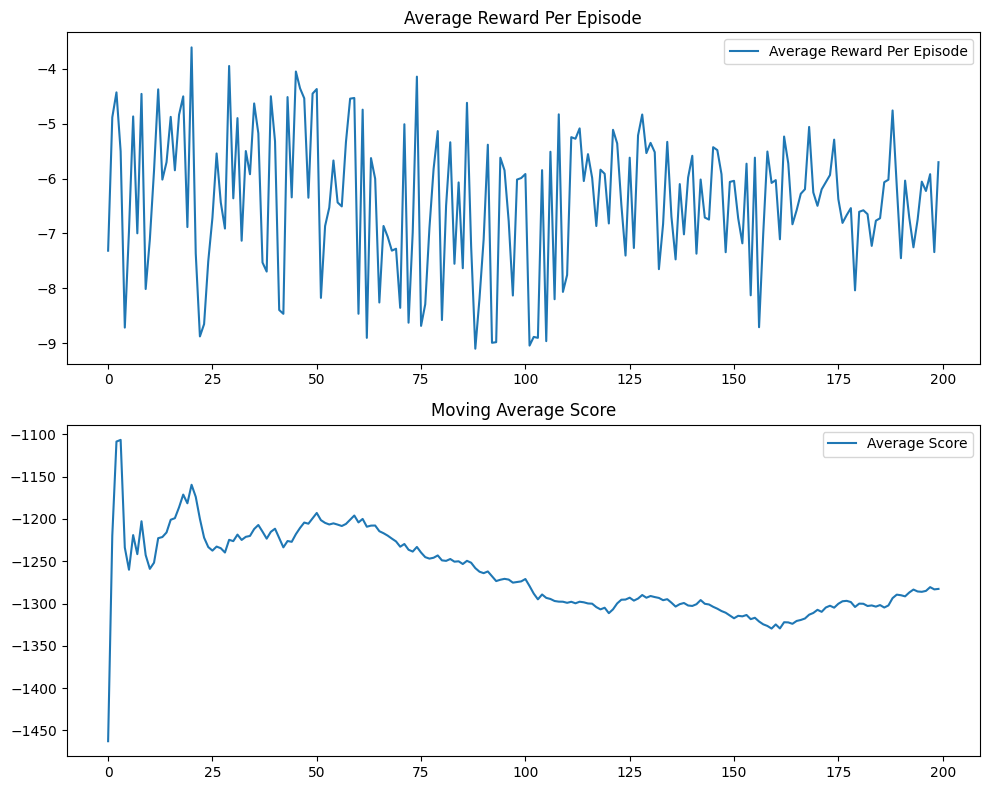

In [5]:
plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
sns.lineplot(x=episode_number, y=base_reward_average, label="Average Reward Per Episode")
plt.title('Average Reward Per Episode')

plt.subplot(2, 1, 2)
sns.lineplot(x=episode_number, y=base_scores_ma, label="Average Score")
plt.title('Moving Average Score')

plt.tight_layout()
plt.show()

# Tune the model

In [43]:
# Setting of the parameters that we wanted to tune
bins = [10, 20, 30]
epsilon_decay = [0.99, 0.97, 0.95, 0.93]
learning_rate = [0.005, 0.01, 0.02, 0.03, 0.04, 0.05]
discount_rate = [0.9, 0.8]

### Number of Bins for Discretization

In [12]:
bins_rewards = [] # Array of Array of Rewards for each Bins & Episode 
bins_average_score = [] # Array of Array of Moving Average Scores for each Bins & Episode
bins_score = [] # Array of Array of Scores for each Bins & Episode
for e in bins:
    bins_scores_ma, bins_res_scores, bins_reward_average, episode_number, bins_step_reward = \
        main(bins=e, filename=f"Bins_Discretization{e}.h5")
    bins_average_score.append(bins_scores_ma)
    bins_rewards.append(bins_reward_average)
    bins_score.append(bins_res_scores)


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 24)                96        
                                                                 
 dense_25 (Dense)            (None, 24)                600       
                                                                 
 dense_26 (Dense)            (None, 10)                250       
                                                                 
Total params: 946 (3.70 KB)
Trainable params: 946 (3.70 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 24)                96        
                                                                 
 dense_28 (Dense)            (None, 24)                600       
                                                                 
 dense_29 (Dense)            (None, 10)                250       
                                                                 
Total params: 946 (3.70 KB)
Trainable params: 946 (3.70 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


episode: 0   score: -1676.363015871601   memory length: 200   epsilon: 0.99
episode: 1   score: -913.6386517496126   memory length: 400   epsilon: 0.9801
episode: 2   score: -1352.0045599953298   memory length: 600   epsilon: 0.9702989999999999
episode: 3   score: -1232.627916503643   memory length: 800   epsilon: 0.96059601
episode: 4   score: -1084.8074060124584   memory length: 1000   epsilon: 0.9509900498999999
episode: 5   score: -1762.5829427553422   memory length: 1200   epsilon: 0.9414801494009999
episode: 6   score: -1409.2083566546883   memory length: 1400   epsilon: 0.9320653479069899
episode: 7   score: -959.2239494931252   memory length: 1600   epsilon: 0.92274469442792
episode: 8   score: -1023.153792720704   memory length: 1800   epsilon: 0.9135172474836407
episode: 9   score: -995.1248157898087   memory length: 2000   epsilon: 0.9043820750088043
episode: 10   score: -1257.8659693417537   memory length: 2200   epsilon: 0.8953382542587163
episode: 11   score: -761.5591278

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 24)                96        
                                                                 
 dense_34 (Dense)            (None, 24)                600       
                                                                 
 dense_35 (Dense)            (None, 20)                500       
                                                                 
Total params: 1196 (4.67 KB)
Trainable params: 1196 (4.67 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


episode: 0   score: -895.3315080059593   memory length: 200   epsilon: 0.99
episode: 1   score: -1324.944318230193   memory length: 400   epsilon: 0.9801
episode: 2   score: -1483.4186428074127   memory length: 600   epsilon: 0.9702989999999999
episode: 3   score: -792.2317789367911   memory length: 800   epsilon: 0.96059601
episode: 4   score: -764.2279603064669   memory length: 1000   epsilon: 0.9509900498999999
episode: 5   score: -1673.7902338362583   memory length: 1200   epsilon: 0.9414801494009999
episode: 6   score: -1185.578409348874   memory length: 1400   epsilon: 0.9320653479069899
episode: 7   score: -1547.5012533965705   memory length: 1600   epsilon: 0.92274469442792
episode: 8   score: -886.4637902271944   memory length: 1800   epsilon: 0.9135172474836407
episode: 9   score: -1228.2400640672206   memory length: 2000   epsilon: 0.9043820750088043
episode: 10   score: -1628.894834022926   memory length: 2200   epsilon: 0.8953382542587163
episode: 11   score: -1356.1744399

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_39 (Dense)            (None, 24)                96        
                                                                 
 dense_40 (Dense)            (None, 24)                600       
                                                                 
 dense_41 (Dense)            (None, 30)                750       
                                                                 
Total params: 1446 (5.65 KB)
Trainable params: 1446 (5.65 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


episode: 0   score: -1407.6213957888858   memory length: 200   epsilon: 0.99
episode: 1   score: -1470.551770422836   memory length: 400   epsilon: 0.9801
episode: 2   score: -979.718561393191   memory length: 600   epsilon: 0.9702989999999999
episode: 3   score: -959.1522290442468   memory length: 800   epsilon: 0.96059601
episode: 4   score: -1389.6481108570838   memory length: 1000   epsilon: 0.9509900498999999
episode: 5   score: -1452.2103595645708   memory length: 1200   epsilon: 0.9414801494009999
episode: 6   score: -1617.8474571423721   memory length: 1400   epsilon: 0.9320653479069899
episode: 7   score: -974.5944974138271   memory length: 1600   epsilon: 0.92274469442792
episode: 8   score: -917.3845406405717   memory length: 1800   epsilon: 0.9135172474836407
episode: 9   score: -1307.149231056924   memory length: 2000   epsilon: 0.9043820750088043
episode: 10   score: -1270.9502975277221   memory length: 2200   epsilon: 0.8953382542587163
episode: 11   score: -1253.8339862

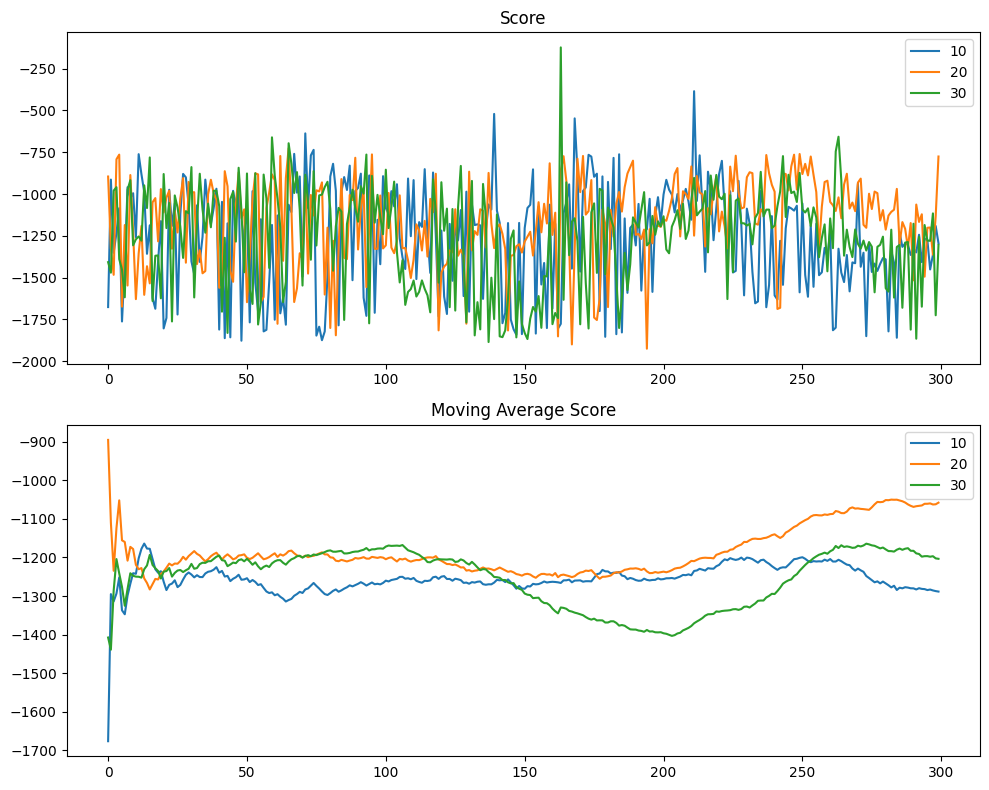

In [14]:
plt.figure(figsize=(10, 8))


plt.subplot(2,1,1)
for i, scores in enumerate(bins):
    sns.lineplot(x=episode_number, y=bins_score[i], label=bins[i])
plt.title('Score')


# # Average Reward Per Episode
# plt.subplot(2, 1, 1)
# for i, scores in enumerate(bins):
#     sns.lineplot(x=episode_number, y=bins_rewards[i], label=bins[i])
# plt.title('Average Reward Per Episode')

# Moving Average Score
plt.subplot(2, 1, 2)
for i, scores in enumerate(bins):
    sns.lineplot(x=episode_number, y=bins_average_score[i], label=bins[i])
plt.title('Moving Average Score')


plt.tight_layout()
plt.show()

- Can pick 30 Bins because it produces an episode with a very good score
- Can pick 20 because it's average is higher than 30


### Learning Rate


In [17]:
lrate_rewards = [] # Array of Array of Rewards for each Episode & Decay
lrate_average_score = [] # Array of Array of Moving Average Scores for each Episode & Decay
lrate_score = [] # Array of Array of Scores for each Episode & Decay

for e in learning_rate:
    lrate_scores_ma, lrate_res_scores, lrate_reward_average, episode_number, lrate_step_reward = \
        main(bins=20, learning_rate=e,  filename=f"learning_rate{e}.h5")
    lrate_average_score.append(lrate_scores_ma)
    lrate_rewards.append(lrate_reward_average)
    lrate_score.append(lrate_res_scores)


Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (None, 24)                96        
                                                                 
 dense_49 (Dense)            (None, 24)                600       
                                                                 
 dense_50 (Dense)            (None, 20)                500       
                                                                 
Total params: 1196 (4.67 KB)
Trainable params: 1196 (4.67 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_51 (Dense)            (None, 24)                96        
                                                                 
 dense_52 (Dense)            (None, 24)                600       
                                                                 
 dense_53 (Dense)            (None, 20)                500       
                                                                 
Total params: 1196 (4.67 KB)
Trainable params: 1196 (4.67 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


episode: 0   score: -1572.6856036724243   memory length: 200   epsilon: 0.99
episode: 1   score: -981.1799767044112   memory length: 400   epsilon: 0.9801
episode: 2   score: -866.2103049817905   memory length: 600   epsilon: 0.9702989999999999
episode: 3   score: -1753.4823001674058   memory length: 800   epsilon: 0.96059601
episode: 4   score: -1772.0464467442864   memory length: 1000   epsilon: 0.9509900498999999
episode: 5   score: -989.8246887469631   memory length: 1200   epsilon: 0.9414801494009999
episode: 6   score: -1760.3135079767471   memory length: 1400   epsilon: 0.9320653479069899
episode: 7   score: -925.8966203391785   memory length: 1600   epsilon: 0.92274469442792
episode: 8   score: -1323.844646620071   memory length: 1800   epsilon: 0.9135172474836407
episode: 9   score: -772.9028200019477   memory length: 2000   epsilon: 0.9043820750088043
episode: 10   score: -1010.1605736615387   memory length: 2200   epsilon: 0.8953382542587163
episode: 11   score: -902.3038229

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_57 (Dense)            (None, 24)                96        
                                                                 
 dense_58 (Dense)            (None, 24)                600       
                                                                 
 dense_59 (Dense)            (None, 20)                500       
                                                                 
Total params: 1196 (4.67 KB)
Trainable params: 1196 (4.67 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


episode: 0   score: -1269.8779970208748   memory length: 200   epsilon: 0.99
episode: 1   score: -1584.2752296285692   memory length: 400   epsilon: 0.9801
episode: 2   score: -1582.0708135641137   memory length: 600   epsilon: 0.9702989999999999
episode: 3   score: -1368.5983276330346   memory length: 800   epsilon: 0.96059601
episode: 4   score: -901.3475077913317   memory length: 1000   epsilon: 0.9509900498999999
episode: 5   score: -988.9696306573262   memory length: 1200   epsilon: 0.9414801494009999
episode: 6   score: -1245.5459689190284   memory length: 1400   epsilon: 0.9320653479069899
episode: 7   score: -1087.4626266173889   memory length: 1600   epsilon: 0.92274469442792
episode: 8   score: -1260.7248833448466   memory length: 1800   epsilon: 0.9135172474836407
episode: 9   score: -1506.390397956492   memory length: 2000   epsilon: 0.9043820750088043
episode: 10   score: -1345.9491076824984   memory length: 2200   epsilon: 0.8953382542587163
episode: 11   score: -1854.786

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_63 (Dense)            (None, 24)                96        
                                                                 
 dense_64 (Dense)            (None, 24)                600       
                                                                 
 dense_65 (Dense)            (None, 20)                500       
                                                                 
Total params: 1196 (4.67 KB)
Trainable params: 1196 (4.67 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


episode: 0   score: -1083.706199470938   memory length: 200   epsilon: 0.99
episode: 1   score: -1374.0698854454458   memory length: 400   epsilon: 0.9801
episode: 2   score: -1078.6710395751104   memory length: 600   epsilon: 0.9702989999999999
episode: 3   score: -1078.159593058423   memory length: 800   epsilon: 0.96059601
episode: 4   score: -1217.7493406910235   memory length: 1000   epsilon: 0.9509900498999999
episode: 5   score: -1288.1802935234532   memory length: 1200   epsilon: 0.9414801494009999
episode: 6   score: -1171.1731799823096   memory length: 1400   epsilon: 0.9320653479069899
episode: 7   score: -1427.104656063922   memory length: 1600   epsilon: 0.92274469442792
episode: 8   score: -884.8019242077365   memory length: 1800   epsilon: 0.9135172474836407
episode: 9   score: -996.5335534725957   memory length: 2000   epsilon: 0.9043820750088043
episode: 10   score: -1009.6927858227335   memory length: 2200   epsilon: 0.8953382542587163
episode: 11   score: -1738.00913

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_69 (Dense)            (None, 24)                96        
                                                                 
 dense_70 (Dense)            (None, 24)                600       
                                                                 
 dense_71 (Dense)            (None, 20)                500       
                                                                 
Total params: 1196 (4.67 KB)
Trainable params: 1196 (4.67 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


episode: 0   score: -905.3868515746485   memory length: 200   epsilon: 0.99
episode: 1   score: -1299.9897956319023   memory length: 400   epsilon: 0.9801
episode: 2   score: -1750.3139234781213   memory length: 600   epsilon: 0.9702989999999999
episode: 3   score: -1291.0402828180834   memory length: 800   epsilon: 0.96059601
episode: 4   score: -893.4231680905358   memory length: 1000   epsilon: 0.9509900498999999
episode: 5   score: -1696.6208791799606   memory length: 1200   epsilon: 0.9414801494009999
episode: 6   score: -894.3667702640167   memory length: 1400   epsilon: 0.9320653479069899
episode: 7   score: -979.5810390875495   memory length: 1600   epsilon: 0.92274469442792
episode: 8   score: -1362.7557158893387   memory length: 1800   epsilon: 0.9135172474836407
episode: 9   score: -1532.4275750716859   memory length: 2000   epsilon: 0.9043820750088043
episode: 10   score: -973.39930842774   memory length: 2200   epsilon: 0.8953382542587163
episode: 11   score: -1659.3086983

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_75 (Dense)            (None, 24)                96        
                                                                 
 dense_76 (Dense)            (None, 24)                600       
                                                                 
 dense_77 (Dense)            (None, 20)                500       
                                                                 
Total params: 1196 (4.67 KB)
Trainable params: 1196 (4.67 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


episode: 0   score: -1669.021453549398   memory length: 200   epsilon: 0.99
episode: 1   score: -1432.4405261001639   memory length: 400   epsilon: 0.9801
episode: 2   score: -1600.7549227431268   memory length: 600   epsilon: 0.9702989999999999
episode: 3   score: -1401.3046930342214   memory length: 800   epsilon: 0.96059601
episode: 4   score: -1749.781430249144   memory length: 1000   epsilon: 0.9509900498999999
episode: 5   score: -1228.2511699209974   memory length: 1200   epsilon: 0.9414801494009999
episode: 6   score: -1185.4555659217638   memory length: 1400   epsilon: 0.9320653479069899
episode: 7   score: -863.7696073959023   memory length: 1600   epsilon: 0.92274469442792
episode: 8   score: -886.6835005880481   memory length: 1800   epsilon: 0.9135172474836407
episode: 9   score: -1339.3953339122597   memory length: 2000   epsilon: 0.9043820750088043
episode: 10   score: -1561.3517153405403   memory length: 2200   epsilon: 0.8953382542587163
episode: 11   score: -1078.8174

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_81 (Dense)            (None, 24)                96        
                                                                 
 dense_82 (Dense)            (None, 24)                600       
                                                                 
 dense_83 (Dense)            (None, 20)                500       
                                                                 
Total params: 1196 (4.67 KB)
Trainable params: 1196 (4.67 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


episode: 0   score: -1188.5930137484484   memory length: 200   epsilon: 0.99
episode: 1   score: -975.5697948018992   memory length: 400   epsilon: 0.9801
episode: 2   score: -1350.3056434668786   memory length: 600   epsilon: 0.9702989999999999
episode: 3   score: -830.9202407828303   memory length: 800   epsilon: 0.96059601
episode: 4   score: -768.0799810137313   memory length: 1000   epsilon: 0.9509900498999999
episode: 5   score: -1821.7381190808655   memory length: 1200   epsilon: 0.9414801494009999
episode: 6   score: -1443.3387158841156   memory length: 1400   epsilon: 0.9320653479069899
episode: 7   score: -881.3322964937934   memory length: 1600   epsilon: 0.92274469442792
episode: 8   score: -897.323471259821   memory length: 1800   epsilon: 0.9135172474836407
episode: 9   score: -1288.8972652172156   memory length: 2000   epsilon: 0.9043820750088043
episode: 10   score: -765.5560739836441   memory length: 2200   epsilon: 0.8953382542587163
episode: 11   score: -825.50485721

In [24]:
len(lrate_score)


12

0 1
1 3
2 5
3 7
4 9
5 11


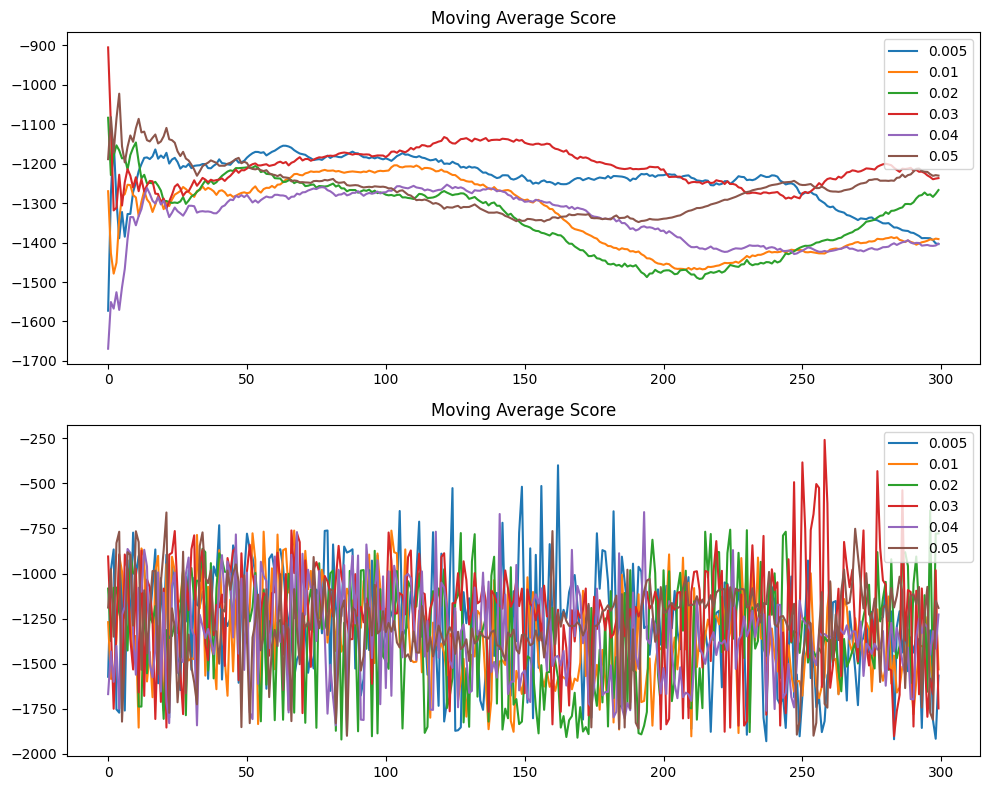

In [40]:
plt.figure(figsize=(10, 8))

# Average Reward Per Episode
# plt.subplot(2, 1, 1)
# for i, scores in enumerate(bins):
#     sns.lineplot(x=episode_number, y=lrate_rewards, label=bins[i])
# plt.title('Average Reward Per Episode')


plt.subplot(2,1,1)
for i in range (len(lrate_score)):
    if i % 2 == 0:
        s = int(i/2)
        # print(s)
        sns.lineplot(x=episode_number, y=lrate_score[i], label=learning_rate[s])
plt.title('Moving Average Score')

# Moving Average Score
plt.subplot(2, 1, 2)
for i in range(len(lrate_score)):
    if i % 2 != 0:
        s = int((i-1)/2)
        print(s,i)
        sns.lineplot(x=episode_number, y=lrate_score[i], label=learning_rate[s])
plt.title('Moving Average Score')



plt.tight_layout()
plt.show()

Best is 0.03

### Epsilon_Decay_Scores

In [44]:
decay_rewards = [] # Array of Array of Rewards for each Episode & Decay
decay_average_score = [] # Array of Array of Moving Average Scores for each Episode & Decay
decay_score = [] # Array of Array of Scores for each Episode & Decay

for e in epsilon_decay:
    decay_scores_ma, decay_res_scores, decay_reward_average, episode_number, decay_step_reward = \
        main(bins=20, learning_rate=0.03, epsilon_decay=e, filename=f"Epislion_decay{e}.h5")
    decay_average_score.append(decay_scores_ma)
    decay_rewards.append(decay_reward_average)
    decay_score.append(decay_res_scores)


Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_96 (Dense)            (None, 24)                96        
                                                                 
 dense_97 (Dense)            (None, 24)                600       
                                                                 
 dense_98 (Dense)            (None, 20)                500       
                                                                 
Total params: 1196 (4.67 KB)
Trainable params: 1196 (4.67 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_99 (Dense)            (None, 24)                96        
                                                                 
 dense_100 (Dense)           (None, 24)                600       
                                                                 
 dense_101 (Dense)           (None, 20)                500       
                                                                 
Total params: 1196 (4.67 KB)
Trainable params: 1196 (4.67 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


episode: 0   score: -1664.0176023610663   memory length: 200   epsilon: 0.99
episode: 1   score: -1502.4039411517358   memory length: 400   epsilon: 0.9801
episode: 2   score: -1433.169122308713   memory length: 600   epsilon: 0.9702989999999999
episode: 3   score: -1499.6760098220611   memory length: 800   epsilon: 0.96059601
episode: 4   score: -1618.4549629052801   memory length: 1000   epsilon: 0.9509900498999999
episode: 5   score: -1281.3741772833134   memory length: 1200   epsilon: 0.9414801494009999
episode: 6   score: -822.8144904863339   memory length: 1400   epsilon: 0.9320653479069899
episode: 7   score: -1190.6097315863933   memory length: 1600   epsilon: 0.92274469442792
episode: 8   score: -1303.167240256809   memory length: 1800   epsilon: 0.9135172474836407
episode: 9   score: -1827.688463475791   memory length: 2000   epsilon: 0.9043820750088043
episode: 10   score: -972.1584182238812   memory length: 2200   epsilon: 0.8953382542587163
episode: 11   score: -1247.84596

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_105 (Dense)           (None, 24)                96        
                                                                 
 dense_106 (Dense)           (None, 24)                600       
                                                                 
 dense_107 (Dense)           (None, 20)                500       
                                                                 
Total params: 1196 (4.67 KB)
Trainable params: 1196 (4.67 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


episode: 0   score: -1395.936082840341   memory length: 200   epsilon: 0.97
episode: 1   score: -908.0713633761351   memory length: 400   epsilon: 0.9409
episode: 2   score: -1825.890705075801   memory length: 600   epsilon: 0.912673
episode: 3   score: -1586.6746547569705   memory length: 800   epsilon: 0.8852928099999999
episode: 4   score: -1549.2655040226869   memory length: 1000   epsilon: 0.8587340256999999
episode: 5   score: -1350.9919988538957   memory length: 1200   epsilon: 0.8329720049289999
episode: 6   score: -1228.8069698160668   memory length: 1400   epsilon: 0.8079828447811299
episode: 7   score: -1547.748510660181   memory length: 1600   epsilon: 0.783743359437696
episode: 8   score: -1618.2641559742956   memory length: 1800   epsilon: 0.7602310586545651
episode: 9   score: -1621.056998063931   memory length: 2000   epsilon: 0.7374241268949281
episode: 10   score: -1199.1641057756035   memory length: 2200   epsilon: 0.7153014030880802
episode: 11   score: -1345.787289

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_111 (Dense)           (None, 24)                96        
                                                                 
 dense_112 (Dense)           (None, 24)                600       
                                                                 
 dense_113 (Dense)           (None, 20)                500       
                                                                 
Total params: 1196 (4.67 KB)
Trainable params: 1196 (4.67 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


episode: 0   score: -1387.949710431304   memory length: 200   epsilon: 0.95
episode: 1   score: -1663.6935530643648   memory length: 400   epsilon: 0.9025
episode: 2   score: -776.9123386699805   memory length: 600   epsilon: 0.8573749999999999
episode: 3   score: -1515.9172664580067   memory length: 800   epsilon: 0.8145062499999999
episode: 4   score: -1527.9759352539083   memory length: 1000   epsilon: 0.7737809374999999
episode: 5   score: -881.1100815144871   memory length: 1200   epsilon: 0.7350918906249998
episode: 6   score: -1423.4783486385354   memory length: 1400   epsilon: 0.6983372960937497
episode: 7   score: -1314.0206055256974   memory length: 1600   epsilon: 0.6634204312890623
episode: 8   score: -1515.1412137809975   memory length: 1800   epsilon: 0.6302494097246091
episode: 9   score: -1641.409152803936   memory length: 2000   epsilon: 0.5987369392383786
episode: 10   score: -1042.9696510451804   memory length: 2200   epsilon: 0.5688000922764596
episode: 11   score: 

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_117 (Dense)           (None, 24)                96        
                                                                 
 dense_118 (Dense)           (None, 24)                600       
                                                                 
 dense_119 (Dense)           (None, 20)                500       
                                                                 
Total params: 1196 (4.67 KB)
Trainable params: 1196 (4.67 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


episode: 0   score: -1418.3372844939643   memory length: 200   epsilon: 0.93
episode: 1   score: -892.2647266535834   memory length: 400   epsilon: 0.8649000000000001
episode: 2   score: -890.8804335705646   memory length: 600   epsilon: 0.8043570000000001
episode: 3   score: -1123.4461167112142   memory length: 800   epsilon: 0.7480520100000001
episode: 4   score: -1316.5977590711852   memory length: 1000   epsilon: 0.6956883693000001
episode: 5   score: -1843.3869782428915   memory length: 1200   epsilon: 0.6469901834490002
episode: 6   score: -1489.08662225443   memory length: 1400   epsilon: 0.6017008706075702
episode: 7   score: -1724.3791825578337   memory length: 1600   epsilon: 0.5595818096650402
episode: 8   score: -1507.2244628954177   memory length: 1800   epsilon: 0.5204110829884875
episode: 9   score: -1391.869319793298   memory length: 2000   epsilon: 0.48398230717929336
episode: 10   score: -1557.3509651166555   memory length: 2200   epsilon: 0.4501035456767428
episode: 

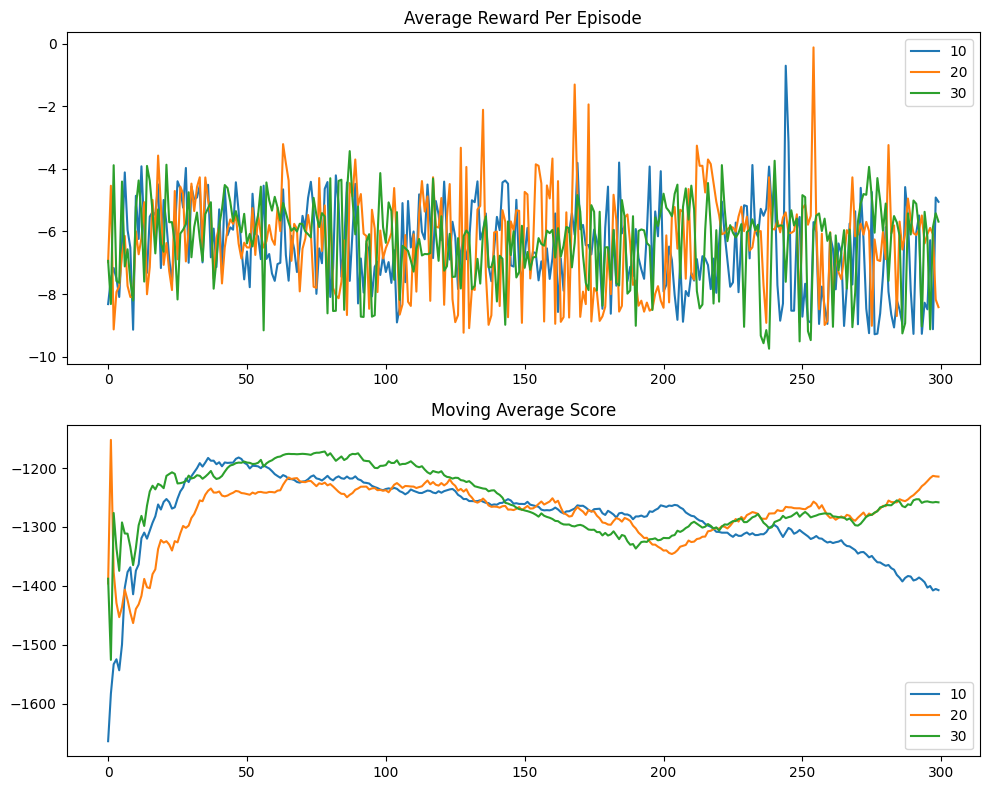

In [45]:
plt.figure(figsize=(10, 8))

# Average Reward Per Episode
plt.subplot(2, 1, 1)
for i, scores in enumerate(bins):
    sns.lineplot(x=episode_number, y=decay_rewards[i], label=bins[i])
plt.title('Average Reward Per Episode')

# Moving Average Score
plt.subplot(2, 1, 2)
for i, scores in enumerate(bins):
    sns.lineplot(x=episode_number, y=decay_average_score[i], label=bins[i])
plt.title('Moving Average Score')

plt.tight_layout()
plt.show()

### Discount Rate

In [ ]:
drate_rewards = [] # Array of Array of Rewards for each Episode & Decay
drate_average_score = [] # Array of Array of Moving Average Scores for each Episode & Decay
drate_score = [] # Array of Array of Scores for each Episode & Decay

for e in discount_rate:
    drate_scores_ma, drate_res_scores, drate_reward_average, episode_number, drate_step_reward = \
        main(bins=10, learning_rate=0.01, epsilon_decay=0.99, discount_rate=e, filename=f"discount_rate{e}.h5")
    drate_score.append(drate_scores_ma)
    drate_rewards.append(drate_reward_average)
    drate_score.append(drate_res_scores)


In [ ]:
plt.figure(figsize=(10, 8))

# Average Reward Per Episode
plt.subplot(2, 1, 1)
for i, scores in enumerate(bins):
    sns.lineplot(x=episode_number, y=decay_rewards, label=bins[i])
plt.title('Average Reward Per Episode')

# Moving Average Score
plt.subplot(2, 1, 2)
for i, scores in enumerate(bins):
    sns.lineplot(x=episode_number, y=decay_average_score, label=bins[i])
plt.title('Moving Average Score')

plt.tight_layout()
plt.show()

### Final DQN Model

In [ ]:
res_scores, res_episodes, episode_number, step_reward = main(epsilon_decay=0.99, learning_rate=0.01, discount_rate=0.8, filename="best_DQN_pendulum.h5")

In [ ]:
sns.lineplot(x=episode_number, y=res_episodes)

### DDPG

In [ ]:
class DDPG:
    def __init__(self):
        return
